In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.svm import SVR

In [2]:
corr_coeff = lambda x,y: np.corrcoef(x, y).tolist()[0][1]

In [3]:
from typing import Union
def sample_weight_y_density(data: Union[np.ndarray, list, pd.Series], bins:int=3):
    """Returns weigths inversely proportional to the density of the given 1-d array. To be used with y data."""
    df_data = pd.DataFrame({"y":data, "label": pd.cut(data, bins=bins, labels=False)})
    df_data["weight"] = df_data["label"].map(df_data["label"].value_counts()/len(y))
    return (1/df_data["weight"]).values

def sample_weight_x_density(data: Union[np.ndarray, pd.Series], bins:int=3):
    """Weight of each sample is inversely proportional to the number of other samples around it. 
    Eucledian distance is used. Radius is computed by deviding the max distance by number of bins."""
    if data.ndim == 1:
        distances = pairwise_distances(data.reshape(-1, 1))
    else:
        distances = pairwise_distances(data)
    max_dist = distances.max().max()
    eps = max_dist/bins
    return 1/((distances <= eps).sum(axis=1)/len(data))

# 1-D case

In [4]:
# function to generate synthetic data
func_1d = lambda x: 5*x + 3 + np.random.randn(x.shape[0])*0.5

In [5]:
X = np.random.randn(100)*0.1
X_test = np.random.randn(20)*0.1
y = func_1d(X)
y_test = func_1d(X_test)

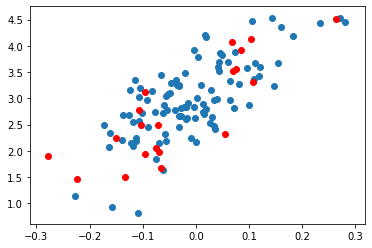

In [6]:
ax = plt.subplot()
_ = ax.scatter(X, y)
_ = ax.scatter(X_test, y_test, c="r")

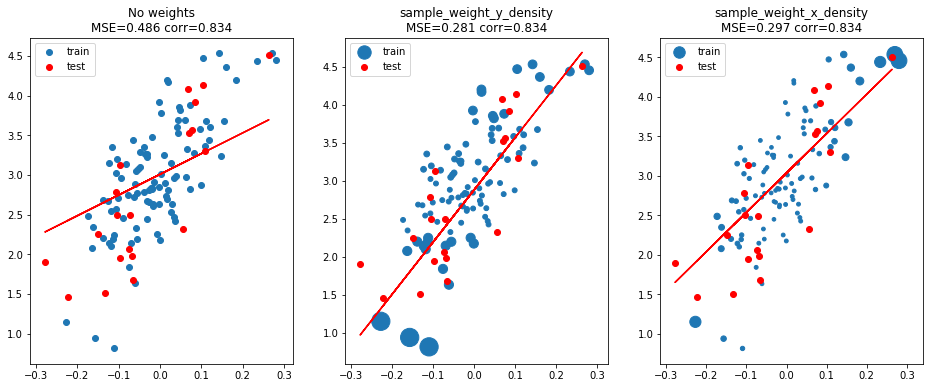

In [7]:
_, axs = plt.subplots(figsize=(16, 6), ncols=3, nrows=1)
for ax, wfunc in zip(axs, [None, sample_weight_y_density, sample_weight_x_density]):
    lr = Ridge()
    if wfunc is None:
        sample_weight = None
        wname = "No weights"
        ax.scatter(X, y, label="train")
    else:
        wname = wfunc.__name__
        if "_x_" in wname:
            sample_weight = wfunc(X, bins=5)
        else:
            sample_weight = wfunc(y, bins=5)
        ax.scatter(X, y, s=sample_weight*10, label="train")
    
    lr = lr.fit(X.reshape(-1, 1), y, sample_weight=sample_weight)
    y_pred = lr.predict(X_test.reshape(-1, 1))
    
    ax.scatter(X_test, y_test, c="r", label="test")
    ax.plot(X_test, y_pred, "r")
    mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
    corr = corr_coeff(y_pred, y_test)
    
    ax.set_title(f"{wname}\nMSE={round(mse, 3)} corr={round(corr, 3)}")
    ax.legend()

# N-d case

In [8]:
func_3d = lambda x: x[0]*3 + x[1]*x[2]**2

In [9]:
X = np.random.randn(100, 3)
X_test = np.random.randn(20, 3)
y = func_3d(X.T)
y_test = func_3d(X_test.T)

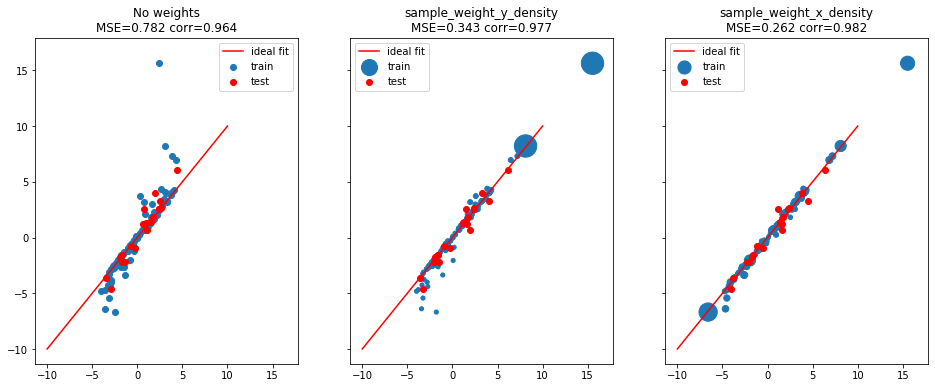

In [10]:
_, axs = plt.subplots(figsize=(16, 6), ncols=3, nrows=1, sharex=True, sharey=True)
for ax, wfunc in zip(axs, [None, sample_weight_y_density, sample_weight_x_density]):
    lr = SVR()
    if wfunc is None:
        sample_weight = None
        wname = "No weights"
    else:
        wname = wfunc.__name__
        if "_x_" in wname:
            sample_weight = wfunc(X, bins=3)
        else:
            sample_weight = wfunc(y, bins=3)
    lr = lr.fit(X, y.reshape(-1), sample_weight=sample_weight)
    
    y_pred_train = lr.predict(X)
    y_pred_test = lr.predict(X_test)
    
    if wfunc is None:
        ax.scatter(y_pred_train, y, label="train")
    else:
        ax.scatter(y_pred_train, y, label="train", s=sample_weight*10)
    ax.scatter(y_pred_test, y_test, c="r", label="test")
    ax.plot([-10,10], [-10,10], "r", label="ideal fit")
    mse = mean_squared_error(y_pred=y_pred_test, y_true=y_test)
    corr = corr_coeff(y_pred_test, y_test)
    
    ax.set_title(f"{wname}\nMSE={round(mse, 3)} corr={round(corr, 3)}")
    ax.legend()